### Summary of Notebook
- This program is executed after the Pre-Processing(Pre-Processing_Data.ipynb) on the data is complete.
- In this program we will build the complete object localisation + classification model , train the model and log results.
- We will take  pre-trained MobileNet base with a basic top layer re-built  and add a regression and a classification head to it.
- At the end of this program , we will have trained model with scores logged .

In [1]:
# Import Genereal libs  libraries

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import statistics as stats
sns.set(color_codes=True)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Last import allows multiple outputs from one cell
import warnings
# Initialize the random number generator
import pickle
import random
random.seed(101)
# Import project specific libs
import tarfile
import os
import matplotlib.image as img
import cv2
import matplotlib.patches as patches
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet import MobileNet
from keras.models import Model,load_model
from keras.layers import Conv2D, Reshape,Flatten,Dense,Dropout,MaxPooling2D ,Input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet import preprocess_input
from keras.utils import to_categorical



In [2]:
print(tf.__version__)

2.11.0


In [3]:
# Useful Configuration/Setting

# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

#Setting to shows all entries in array displayed
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Train_Util:
  #This Utility class performs EDA on the input data

  #Constructor func
 def __init__(self):
    self.imageFilepath="/content/drive/MyDrive/Object_Localisation/Data_Set/images/"
    self.ip_dataframe=pickle.load(open('/content/drive/MyDrive/Object_Localisation/Pickled_Data/IpDataFrame.pickle','rb'))
    print("# Shape #")
    # Add a filename extension
    self.ip_dataframe['filename']=self.ip_dataframe['image_name'] +'.jpg'
    print(self.ip_dataframe.shape)
    print("##########################################################################")
    #print("# Sample Records #")
    #print(self.ip_dataframe.sample(5))
    #print("##########################################################################")
    #print("# First 5  Records #")
    #print(self.ip_dataframe.head(5))
    #print("##########################################################################")
    self.rowSize=self.ip_dataframe.shape[0]
    #image length and width we desire
    self.expImageLength=256
    self.expImageWidth=256
    #Load Train and Test Tensors
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Train.npy')):
      self.X_Train=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Train.npy')
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Train_ClassLabel.npy')):
      self.Y_Train_ClassLabel=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Train_ClassLabel.npy')
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Train_RegLabel.npy')):
      self.Y_Train_RegLabel=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Train_RegLabel.npy')

    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Test.npy')):
      self.X_Test=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Test.npy')
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Test_ClassLabel.npy')):
      self.Y_Test_ClassLabel=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Test_ClassLabel.npy')
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Test_RegLabel.npy')):
      self.Y_Test_RegLabel=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Test_RegLabel.npy')
    return

 def modelPreprocLabelsForClassification(self):
   #Function to convert labels to one hot vectors
   #Lets check the label range its from 1-37
   #NTS so there is no 0 class
   #print(np.unique(self.Y_Train_ClassLabel))
   #print(np.unique(self.Y_Test_ClassLabel))
   #Lets convert the labels from 1-37 to 0-36
   self.Y_Train_ClassLabel=self.Y_Train_ClassLabel-1
   self.Y_Test_ClassLabel=self.Y_Test_ClassLabel-1
   #Check rage again
   #print(np.unique(self.Y_Train_ClassLabel))
   #print(np.unique(self.Y_Test_ClassLabel))

   self.Y_Train_ClassLabel = to_categorical(self.Y_Train_ClassLabel, num_classes=37)
   self.Y_Test_ClassLabel = to_categorical(self.Y_Test_ClassLabel, num_classes=37)
   #print("Y_Train.shape",self.Y_Train_ClassLabel.shape)
   #print("Y_Val.shape",self.Y_Test_ClassLabel.shape)
   return



 def modelPreprocDataForMobileNet(self):
    #Perform the necessary pre-processing for the model
    for index,eachRowData in enumerate(self.X_Train):
     self.X_Train[index]=preprocess_input(self.X_Train[index]) 
    for index,eachRowData in enumerate(self.X_Test):
     self.X_Test[index]=preprocess_input(self.X_Test[index]) 
    return



 def buildModel(self):
    #Build the model
    ALPHA = 1.0
    classAndRegModelBase = MobileNet(input_shape=(self.expImageLength,self.expImageWidth,3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in classAndRegModelBase.layers:
        layer.trainable = False
    # Add new top layer for Regression Head
    classAndRegModel= classAndRegModelBase.layers[-1].output
    classAndRegModel= Flatten()(classAndRegModel)
    classOutLayer = Dense(units=37,activation='softmax',name='class_output')(classAndRegModel) 
    regOutLayer   = Dense(units=4,name='box_output')(classAndRegModel)

    self.cvmodel= Model(inputs=classAndRegModelBase.input, outputs=[classOutLayer,regOutLayer])
    return 



 def trainModel(self):
    self.cvmodel.summary() # Print summary
    # Use earlystopping
    # If val_iou does not increase by 001 in 5 epochs , stop
    callback = EarlyStopping(monitor='val_class_output_accuracy', patience=5, min_delta=0.01)
    mc = ModelCheckpoint('/content/drive/MyDrive/Object_Localisation/Pickled_Data/bestWieghts.h5', monitor='val_class_output_accuracy', mode='max', verbose=1, save_best_only=True,save_weights_only=True)
    #Define Loss Functions
    losses = { 
    "box_output": "mse",
    "class_output": "categorical_crossentropy"
    }
    # Here you can give more or less weightage to each loss. 
    # If you think that detection is harder then the classification then you can 
    # Try assinging it more weight
    # NTS:RK: In this case , we did not need to do this because we had already tried the classification and regression problem ...
    #... both standalone and both were getting good results with the basic top layer .
    loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }
 
    # Set the Metrics
    metrics = {
    'class_output': 'accuracy', 
    'box_output':  IoU
    }
 
    self.cvmodel.compile(loss=losses, optimizer="adam", metrics=metrics) # Regression loss is CE

    # Fit the model
    self.cvmodel.fit(self.X_Train,[self.Y_Train_ClassLabel,self.Y_Train_RegLabel], validation_data=(self.X_Test,[self.Y_Test_ClassLabel,self.Y_Test_RegLabel]), epochs=7,batch_size=32,callbacks=[callback,mc])
    return

 def runInference(self):
    # We will be running runInference with a new object instance of this class because we want to keep it independant
    #Ideally this method shoould have been a 'static' method, for now just going ahead
    # Hence some steps like pre-processing,compiling model will need to be done again
    # NTS: Clarifying this  just in case there is a doubt as to why things like pre-proc is being done again
    #Load the best model
    self.cvmodel.load_weights('/content/drive/MyDrive/Object_Localisation/Pickled_Data/bestWieghts.h5')
    #we have to compile model, rememebr we recreated with saved weights(new object instance) , so its not the old model which was already compiled
    losses = { 
    "box_output": "mse",
    "class_output": "categorical_crossentropy"
    }
    loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }
    metrics = {
    'class_output': 'accuracy', 
    'box_output':  IoU
    }
    self.cvmodel.compile(loss=losses, optimizer="adam", metrics=metrics) # Regression loss is CE

    #Lets pick a sample from Test
    preProcTestImage= preprocess_input(self.X_Test[701])
    self.modelPreprocLabelsForClassification()
    print("##########################################################################")
    print("Actual Label ",np.argmax(self.Y_Test_ClassLabel[701]))
    #Note here model expects shape expected shape=(None, 256, 256, 3)and we are giving found shape=(256, 256, 3)
    # So we must reshape
    #Looks like for training we didnt do because mobile net pre-proc lib takes care of reshaping
    prediction=self.cvmodel.predict(preProcTestImage.reshape(1,256,256,3))
    class_label_pred=prediction[0]
    class_label=np.argmax(class_label_pred)
    Reg_label=prediction[1]

    print("##########################################################################")
    print('Predicted label',class_label)
    print("##########################################################################")
    #Lets get the breed name from the label(which is the id)
    #print(self.ip_dataframe.sample(10))
    final_label=class_label + 1
    #print(final_label)
    rows=self.ip_dataframe[self.ip_dataframe['id']== str(final_label)]
    # Take any one row and extract breed name
    name=rows.iloc[0,0][0:rows.iloc[0,0].rfind('_')]
    #print(name)
  


    # Lets view same sample PREDICTION on an image
    im=self.X_Test[701]
    # Show resized image with Box
    #fig,ax = plt.subplots(1)
    fig = plt.figure(figsize=(7,7))
    ax=plt.subplot(1,1,1)
    ax.imshow(im)
    ax.set_title(name)
    ax.imshow(im)
    res_x0=Reg_label[0][0]
    res_y0=Reg_label[0][1]
    res_x1=Reg_label[0][2]
    res_y1=Reg_label[0][3]
    rect = patches.Rectangle((res_x0, res_y0), res_x1 - res_x0, res_y1 - res_y0, linewidth=2, edgecolor='r', facecolor='none')
    #ax.add_patch(rect)
    plt.show()
    return


In [ ]:
# Define evaluation metric

def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection
    # rk - again to repeat we know why he has minues , taken 2 times 

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tf.keras.backend.epsilon()), 4)# rounded to 4 
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou
    # this is one number for the whole model

def IoU(y_true, y_pred):
    iou = tf.py_function(IOU, [y_true, y_pred], Tout=tf.float32)
    return iou  
  # This is a wrapper funcction'''

     


In [ ]:
if __name__ == "__main__":
  # Build Model with base MobileNet and basic top layer
  objTrainModel=Train_Util()
  objTrainModel.modelPreprocLabelsForClassification()
  objTrainModel.modelPreprocDataForMobileNet()
  objTrainModel.buildModel()
  objTrainModel.trainModel()

# Shape #
(3671, 13)
##########################################################################


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 128, 128, 32  128         ['conv1[0][0]']                  
                                )                                                             

# Shape #
(3671, 13)
##########################################################################


##########################################################################
Actual Label  35
1/1 [==============================] - 1s 1s/step


##########################################################################
Predicted label 35
##########################################################################


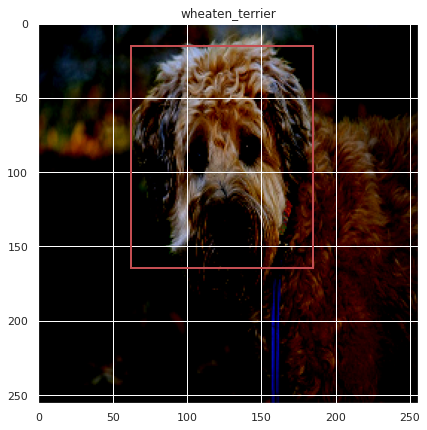

In [ ]:
# Run an inference on the best model obtained  

if __name__ == "__main__":
  objTrainModel= Train_Util()
  #get the best model
  objTrainModel.buildModel()
  # loads best weights and runs model
  objTrainModel.runInference()

### Result
- We built a model capable of doing object localisition + object classification in a single network
- The scores of the model as displayed in the logs were accuracy= 0.9955  and IoU = 0.9452 on the validation/testing data set